In [2]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN


In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTENC
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [6]:
import tensorflow.keras.backend as K # Import keras backend

def focal_loss(gamma=2., alpha=0.40):
    def focal_loss_fixed(y_true, y_pred):
        # K = keras.backend  # Define K here using keras.backend - No need for this line now
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - \
               K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed


In [7]:
# === Load and preprocess data ==
df = pd.read_csv("carclaims.csv")
df["FraudFound"] = df["FraudFound"].map({"Yes": 1, "No": 0})
df.drop(columns=["PolicyNumber", "RepNumber", "Year", "Age"], inplace=True)

X = df.drop(columns=["FraudFound"])
y = df["FraudFound"]

In [8]:
# Identify column types
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Define encoding strategies
one_hot_cols = [
    "Month", "MonthClaimed", "DayOfWeek", "DayOfWeekClaimed", "Sex", "MaritalStatus",
    "AccidentArea", "Fault", "PolicyType", "VehicleCategory", "PoliceReportFiled",
    "WitnessPresent", "AgentType", "BasePolicy", "WeekOfMonth", "WeekOfMonthClaimed"
]

ordinal_cols = [
    "VehiclePrice", "Days:Policy-Accident", "Days:Policy-Claim", "PastNumberOfClaims",
    "AgeOfVehicle", "AgeOfPolicyHolder", "NumberOfSuppliments", "AddressChange-Claim",
    "NumberOfCars", "Deductible", "DriverRating"
]

embedding_col = ["Make"]

In [9]:
print(tabulate(X.head(), headers='keys', tablefmt='fancy_grid'))

╒════╤═════════╤═══════════════╤═════════════╤════════╤════════════════╤════════════════════╤════════════════╤══════════════════════╤════════╤═════════════════╤═══════════════╤═══════════════════╤═══════════════════╤══════════════════╤══════════════╤════════════════╤════════════════════════╤═════════════════════╤══════════════════════╤════════════════╤═════════════════════╤═════════════════════╤══════════════════╤═════════════╤═══════════════════════╤═══════════════════════╤════════════════╤══════════════╕
│    │ Month   │   WeekOfMonth │ DayOfWeek   │ Make   │ AccidentArea   │ DayOfWeekClaimed   │ MonthClaimed   │   WeekOfMonthClaimed │ Sex    │ MaritalStatus   │ Fault         │ PolicyType        │ VehicleCategory   │ VehiclePrice     │   Deductible │   DriverRating │ Days:Policy-Accident   │ Days:Policy-Claim   │ PastNumberOfClaims   │ AgeOfVehicle   │ AgeOfPolicyHolder   │ PoliceReportFiled   │ WitnessPresent   │ AgentType   │ NumberOfSuppliments   │ AddressChange-Claim   │ NumberOf

In [10]:
print("ordinal_cols")
print(ordinal_cols, len(ordinal_cols))
print("one_hot_cols")
print(one_hot_cols,len(one_hot_cols))
print("numeric_cols")
print(numeric_cols,len(numeric_cols))

ordinal_cols
['VehiclePrice', 'Days:Policy-Accident', 'Days:Policy-Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars', 'Deductible', 'DriverRating'] 11
one_hot_cols
['Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed', 'Sex', 'MaritalStatus', 'AccidentArea', 'Fault', 'PolicyType', 'VehicleCategory', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'BasePolicy', 'WeekOfMonth', 'WeekOfMonthClaimed'] 16
numeric_cols
['WeekOfMonth', 'WeekOfMonthClaimed', 'Deductible', 'DriverRating'] 4


In [11]:
print(df.columns[df.isna().any()].tolist())

[]


In [12]:

print(df['NumberOfCars'].unique())


['3 to 4' '1 vehicle' '2 vehicles' '5 to 8' 'more than 8']


In [13]:
categorical_cols_cleaned = list(set(one_hot_cols + ordinal_cols + embedding_col))
remaining_cols = [col for col in X.columns if col not in categorical_cols_cleaned]
final_numeric_cols = [col for col in remaining_cols if col in numeric_cols]

# Map 'Make' to integer indices for embedding
make_vocab = X["Make"].astype("category").cat.categories.tolist()
make_to_idx = {cat: i for i, cat in enumerate(make_vocab)}
X["Make_encoded"] = X["Make"].map(make_to_idx)

# Save embedding inputs
make_input = X["Make_encoded"].values
X = X.drop(columns=["Make"])

# ---------------------------
# 2. Preprocessing Pipelines
# ---------------------------

# numeric_transformer = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler())
# ])

one_hot_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

ordinal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("onehot", one_hot_transformer, one_hot_cols),
    ("ordinal", ordinal_transformer, ordinal_cols)
])

In [14]:

# ---------------------------
# 3. Train/Test Split & Oversampling
# ---------------------------

X_train, X_test, y_train, y_test, make_train, make_test = train_test_split(
    X, y, make_input, test_size=0.2, stratify=y, random_state=42
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)


In [15]:
print(tabulate(X_train_proc[:5]))

-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  0  1  0  0  0  1  1  0  1  0  0  1  0  0  0  1  0  0  0  0  1  0  0  0  3  2  1  4  3  2  3  0  1  3
0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  1  0  0  0  1  0  1  0  0  1  0  0  0  0  0  0  0  1  0  1  0  1  0  1  0  0  0  1  0  0  1  0  0  0  0  1  0  0  0  3  2  2  4  4  1  3  0  1  0
0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  1  0  1  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0

In [16]:
# Apply ADASYN to numeric+encoded inputs only
print("Class distribution before ADASYN:")
print(y_train.value_counts(normalize=True))
adasyn = ADASYN(random_state=42, sampling_strategy=0.7)
X_train_res, y_train_res = adasyn.fit_resample(X_train_proc, y_train)

# Calculate the oversampling ratio
oversampling_ratio = len(y_train_res) / len(y_train)

# Repeat make_train based on the ratio, ensuring the length matches y_train_res
make_train_res = np.repeat(make_train, repeats=int(oversampling_ratio))

# Adjust the length of make_train_res if necessary to match y_train_res
make_train_res = make_train_res[:len(y_train_res)]
print("Class distribution after ADASYN:")
print(pd.Series(y_train_res).value_counts(normalize=True))

Class distribution before ADASYN:
FraudFound
0    0.940175
1    0.059825
Name: proportion, dtype: float64
Class distribution after ADASYN:
FraudFound
0    0.593218
1    0.406782
Name: proportion, dtype: float64


In [17]:
# ######### class seperation before and after ADAYSN ###########

# from sklearn.manifold import TSNE

# # --- Before ADASYN ---

# # Apply t-SNE to original data
# tsne_before = TSNE(n_components=2, random_state=42)
# X_reduced_before = tsne_before.fit_transform(X_train_proc)

In [18]:
# # Create DataFrame for plotting
# # Use the length of X_reduced_before to create an appropriate index
# df_plot_before = pd.DataFrame({
#     'tsne_1': X_reduced_before[:, 0],
#     'tsne_2': X_reduced_before[:, 1],
#     'FraudFound': y_train[:len(X_reduced_before)], # Subset y_train to match the length of X_reduced_before
#     'Dataset': 'Before ADASYN' # Add a column to identify the dataset
# })

In [19]:
# # --- After ADASYN ---

# # Apply t-SNE to oversampled data
# tsne_after = TSNE(n_components=2, random_state=42)
# X_reduced_after = tsne_after.fit_transform(X_train_res)

In [20]:
# # Create DataFrame for plotting
# # Use the length of X_reduced_after to create an appropriate index
# df_plot_after = pd.DataFrame({
#     'tsne_1': X_reduced_after[:, 0],
#     'tsne_2': X_reduced_after[:, 1],
#     'FraudFound': y_train_res[:len(X_reduced_after)], # Subset y_train_res to match the length of X_reduced_after
#     'Dataset': 'After ADASYN' # Add a column to identify the dataset
# })

# # Concatenate the DataFrames
# df_plot_combined = pd.concat([df_plot_before, df_plot_after])

# # Plot side-by-side using Seaborn
# plt.figure(figsize=(12, 6)) # Adjust figure size as needed
# sns.scatterplot(
#     x='tsne_1', y='tsne_2', hue='FraudFound', style='Dataset', # Use style to differentiate datasets
#     data=df_plot_combined, palette='viridis', alpha=0.7
# )
# plt.title('t-SNE Visualization Before and After ADASYN')
# plt.show()

In [21]:
# plt.figure(figsize=(6, 6))  # Adjust figure size as needed
# sns.scatterplot(
#     x='tsne_1', y='tsne_2', hue='FraudFound',
#     data=df_plot_before, palette='viridis', alpha=0.7
# )
# plt.title('t-SNE Visualization Before ADASYN')
# plt.show()

# plt.figure(figsize=(6, 6))  # Adjust figure size as needed
# sns.scatterplot(
#     x='tsne_1', y='tsne_2', hue='FraudFound',
#     data=df_plot_after, palette='viridis', alpha=0.7
# )
# plt.title('t-SNE Visualization After ADASYN')
# plt.show()

In [22]:
# ---------------------------
# 4. Optimal Feature Selection
# ---------------------------

mi_scores = mutual_info_classif(X_train_res, y_train_res, random_state=42)
sorted_indices = np.argsort(mi_scores)[::-1]

In [23]:

# Try different top-k features
best_auc = 0
best_k = 0
best_features = None
for k in range(20, X_train_res.shape[1], 10):
    top_k_indices = sorted_indices[:k]
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []
    for train_idx, val_idx in skf.split(X_train_res[:, top_k_indices], y_train_res):
        model = models.Sequential([
            layers.Dense(64, activation="relu", input_shape=(k,)),
            layers.Dense(32, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])
        model.fit(X_train_res[train_idx][:, top_k_indices], y_train_res[train_idx], epochs=5, batch_size=64, verbose=0)
        auc = model.evaluate(X_train_res[val_idx][:, top_k_indices], y_train_res[val_idx], verbose=0)[1]
        aucs.append(auc)
    avg_auc = np.mean(aucs)
    if avg_auc > best_auc:
        best_auc = avg_auc
        best_k = k
        best_features = top_k_indices

X_train_final = X_train_res[:, best_features]
X_test_final = X_test_proc[:, best_features]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [24]:

class_weights_array = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train_res)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

In [25]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define focal loss
def focal_loss(gamma=2., alpha=0.40):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt_1, gamma) * tf.keras.backend.log(pt_1)) - \
               tf.keras.backend.mean((1 - alpha) * tf.keras.backend.pow(pt_0, gamma) * tf.keras.backend.log(1. - pt_0))
    return focal_loss_fixed

# Build improved DNN model
def build_improved_model(input_dim, learning_rate=1e-3):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.15))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=focal_loss(gamma=2., alpha=0.30),
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model


In [26]:
# Assuming you want a 20% validation split from the training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_final, y_train_res, test_size=0.2, stratify=y_train_res, random_state=42
)

In [27]:
model = build_improved_model(input_dim=X_train.shape[1])
model.summary()
history =model.fit(X_train, y_train, epochs=35, batch_size=256, validation_data=(X_val, y_val),
          callbacks=[EarlyStopping(patience=6, restore_best_weights=True)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 128)            │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 21,729 (84.88 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5601 - auc: 0.5660 - loss: 0.1105 - val_accuracy: 0.6259 - val_auc: 0.7903 - val_loss: 0.0644
Epoch 2/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6440 - auc: 0.7221 - loss: 0.0714 - val_accuracy: 0.6149 - val_auc: 0.8294 - val_loss: 0.0566
Epoch 3/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6691 - auc: 0.7755 - loss: 0.0634 - val_accuracy: 0.6390 - val_auc: 0.8506 - val_loss: 0.0533
Epoch 4/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6685 - auc: 0.7888 - loss: 0.0607 - val_accuracy: 0.6638 - val_auc: 0.8571 - val_loss: 0.0519
Epoch 5/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6875 - auc: 0.8157 - loss: 0.0570 - val_accuracy: 0.6512 - val_auc: 0.8618 - val_loss: 0.0518
Epoch 6/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6908 - auc: 0.8269 - loss: 0.0550 - val_accuracy: 0.6471 - val_auc: 0.8700 - val_loss: 0.0509
Epoch 7/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step -

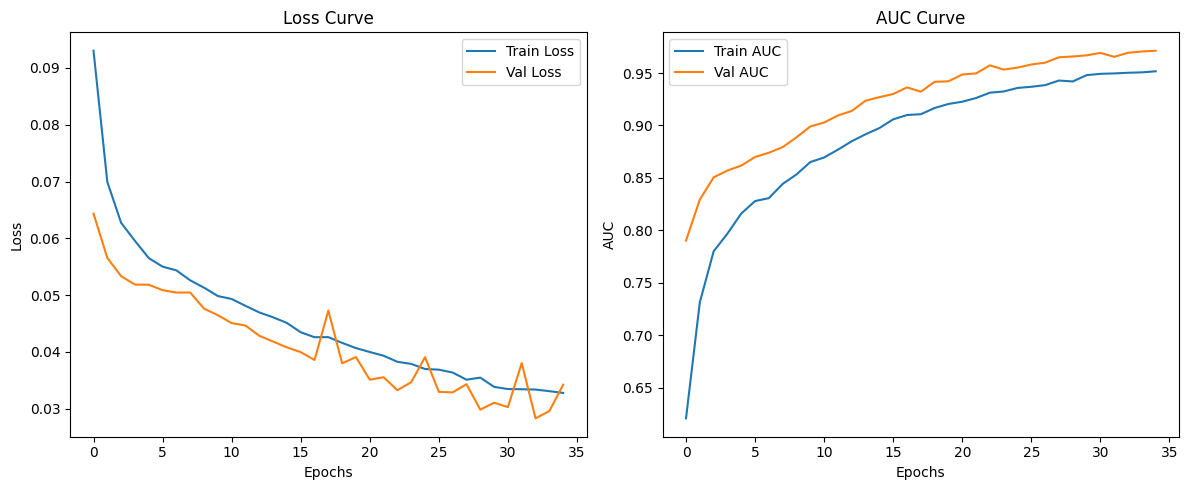

In [28]:
# Plot training and validation loss and AUC
history_dict = history.history

plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# AUC Curve
plt.subplot(1, 2, 2)
plt.plot(history_dict['auc'], label='Train AUC')
plt.plot(history_dict['val_auc'], label='Val AUC')
plt.title('AUC Curve')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Optimal Threshold based on F1 Score: 0.2386

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.67      0.80      2899
           1       0.13      0.79      0.23       185

    accuracy                           0.68      3084
   macro avg       0.56      0.73      0.51      3084
weighted avg       0.93      0.68      0.76      3084



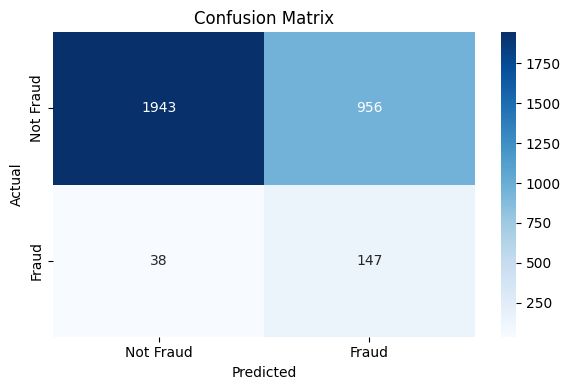

In [29]:
#from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
#import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np

# 1. Predict probabilities
# X_test_final = preprocessor.transform(X_test) # This is what you originally had
X_test_final = X_test_proc[:, best_features] # Applying feature selection to X_test_proc using the best features as done for X_train_final
# Now use the transformed data for prediction
y_pred_probs = model.predict(X_test_final).ravel()


# 2. Optional: Tune threshold for better recall (use only if needed)
prec, rec, thresholds = precision_recall_curve(y_test, y_pred_probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]

# Use beta > 1 to emphasize recall
beta = 1.5
f1_weighted = (1 + beta**2) * (prec * rec) / ((beta**2 * prec) + rec + 1e-6)

# Find threshold that maximizes the weighted F1 score
best_thresh = thresholds[np.argmax(f1_weighted)]

print(f"Optimal Threshold based on F1 Score: {best_thresh:.4f}")

# 3. Apply optimal threshold
y_pred_labels = (y_pred_probs >= best_thresh).astype(int)

# 4. Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_labels))

# 5. Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K
import tensorflow as tf

# Focal Loss Function
def focal_loss(gamma=2., alpha=0.30):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        loss = -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
        return loss
    return focal_loss_fixed

# Improved Model
def build_refined_model(input_dim, learning_rate=1e-3):
    model = Sequential()

    model.add(Dense(128, input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.25))  # reduced dropout

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.25))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.1))

    model.add(Dense(8))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=RMSprop(learning_rate=learning_rate),
        loss=focal_loss(gamma=2., alpha=0.30),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model


In [31]:


#### WITHOUT USING TOP-K FEATURES
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_res, y_train_res, test_size=0.2, stratify=y_train_res, random_state=42 # Use X_train_res instead of X_train_proc and y_train_res instead of y_train
# )

### USING TOP K FEATURES###

X_train, X_val, y_train, y_val = train_test_split(
    X_train_final, y_train_res, test_size=0.2, stratify=y_train_res, random_state=42 # Use X_train_res instead of X_train_proc and y_train_res instead of y_train
)

In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
input_dim = X_train.shape[1]
model = build_refined_model(input_dim)
callbacks = [
    EarlyStopping(monitor='val_auc', patience=7, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=4, mode='max', min_lr=1e-5)
]

class_weight = {0: 1.0, 1: 3.0}

history =model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_val, y_val),
          callbacks=[EarlyStopping(patience=8, restore_best_weights=True,)], class_weight=class_weight)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5925 - auc: 0.6565 - loss: 0.2192 - val_accuracy: 0.6983 - val_auc: 0.8060 - val_loss: 0.0783
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6996 - auc: 0.7765 - loss: 0.1305 - val_accuracy: 0.6840 - val_auc: 0.8385 - val_loss: 0.0570
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6976 - auc: 0.8174 - loss: 0.1061 - val_accuracy: 0.6755 - val_auc: 0.8509 - val_loss: 0.0522
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7040 - auc: 0.8390 - loss: 0.0975 - val_accuracy: 0.6898 - val_auc: 0.8662 - val_loss: 0.0503
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6922 - auc: 0.8445 - loss: 0.0966 - val_accuracy: 0.6939 - val_auc: 0.8736 - val_loss: 0.0492
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7164 - auc: 0.8603 - loss: 0.0921 - val_accuracy: 0.7717 - val_auc: 0.8850 - val_loss: 0.0474
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step -

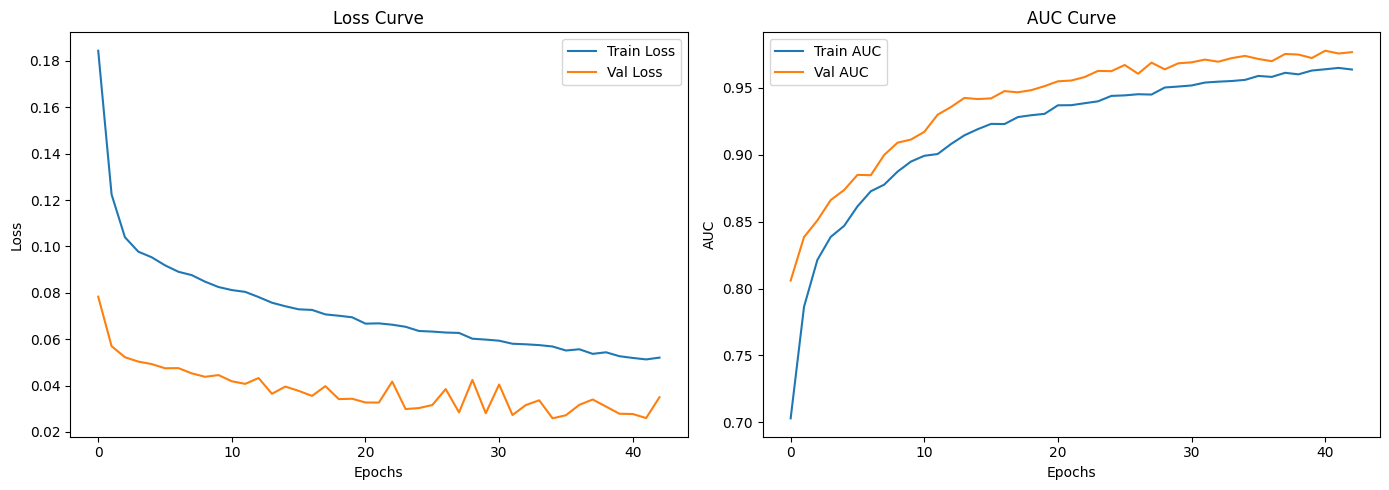

In [33]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # AUC Curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Optimal Threshold based on F1 Score: 0.2588

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      2899
           1       0.14      0.70      0.23       185

    accuracy                           0.72      3084
   macro avg       0.56      0.71      0.53      3084
weighted avg       0.92      0.72      0.79      3084



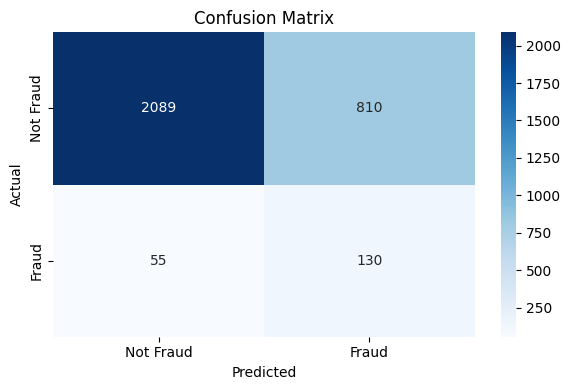

In [34]:
# from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# 1. Predict probabilities
# X_test_final = preprocessor.transform(X_test)  # Incorrect: Transforms using all features
X_test_final = X_test_proc[:, best_features]  # Correct: Applies feature selection
# Now use the transformed data for prediction
y_pred_probs = model.predict(X_test_final).ravel()


# 2. Optional: Tune threshold for better recall (use only if needed)
prec, rec, thresholds = precision_recall_curve(y_test, y_pred_probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]

print(f"Optimal Threshold based on F1 Score: {best_thresh:.4f}")

# 3. Apply optimal threshold
y_pred_labels = (y_pred_probs >= best_thresh).astype(int)

# 4. Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_labels))

# 5. Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [54]:

# === [Soft Voting Ensemble with DNN + XGBoost] ===

# Step 1: Import required libraries
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np

# Step 2: Train an XGBoost model (using same train/val split as DNN)
from xgboost import XGBClassifier

# Count of class labels to compute scale_pos_weight
neg, pos = np.bincount(y_train)
scale = neg / pos

xgb_model = XGBClassifier(
    n_estimators=500,              # More trees
    learning_rate=0.05,            # Slower learning
    max_depth=6,                   # Prevents overfitting
    min_child_weight=5,            # Minimum instances in a leaf
    gamma=0.2,                     # Minimum loss reduction to make a split
    subsample=0.8,                 # Row subsample ratio
    colsample_bytree=0.8,          # Feature subsample ratio
    reg_alpha=0.5,                 # L1 regularization
    reg_lambda=1.0,                # L2 regularization
    scale_pos_weight=scale,        # Handles imbalance (major key!)
    objective='binary:logistic',
    eval_metric='auc',             # Better for fraud detection than logloss
    use_label_encoder=False,
    random_state=42,
    verbosity=1
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=True)




[0]	validation_0-auc:0.85333
[1]	validation_0-auc:0.86868
[2]	validation_0-auc:0.90932
[3]	validation_0-auc:0.92530
[4]	validation_0-auc:0.92639
[5]	validation_0-auc:0.94520
[6]	validation_0-auc:0.95494


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:07:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-auc:0.95988
[8]	validation_0-auc:0.95961
[9]	validation_0-auc:0.95960
[10]	validation_0-auc:0.96132
[11]	validation_0-auc:0.96498
[12]	validation_0-auc:0.96728
[13]	validation_0-auc:0.96875
[14]	validation_0-auc:0.96932
[15]	validation_0-auc:0.97018
[16]	validation_0-auc:0.97099
[17]	validation_0-auc:0.97114
[18]	validation_0-auc:0.97134
[19]	validation_0-auc:0.97201
[20]	validation_0-auc:0.97274
[21]	validation_0-auc:0.97312
[22]	validation_0-auc:0.97301
[23]	validation_0-auc:0.97374
[24]	validation_0-auc:0.97389
[25]	validation_0-auc:0.97433
[26]	validation_0-auc:0.97500
[27]	validation_0-auc:0.97513
[28]	validation_0-auc:0.97540
[29]	validation_0-auc:0.97559
[30]	validation_0-auc:0.97634
[31]	validation_0-auc:0.97670
[32]	validation_0-auc:0.97690
[33]	validation_0-auc:0.97751
[34]	validation_0-auc:0.97758
[35]	validation_0-auc:0.97782
[36]	validation_0-auc:0.97819
[37]	validation_0-auc:0.97844
[38]	validation_0-auc:0.97874
[39]	validation_0-auc:0.97882
[40]	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2899
           1       0.34      0.06      0.11       185

    accuracy                           0.94      3084
   macro avg       0.64      0.53      0.54      3084
weighted avg       0.91      0.94      0.92      3084



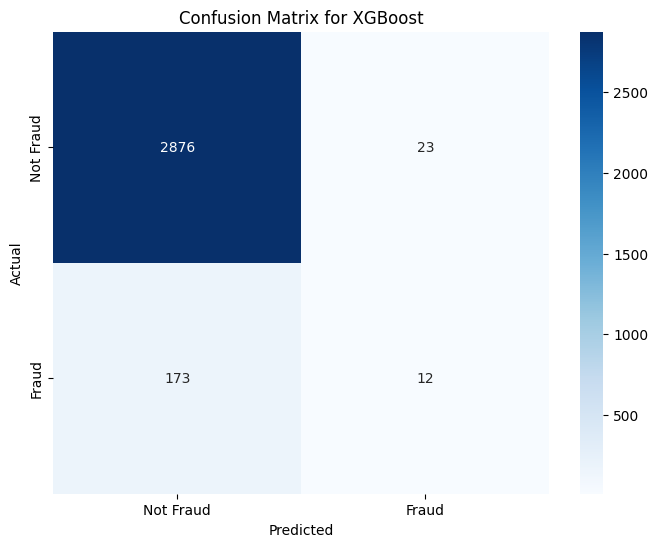

In [58]:
# prompt: code for classification report and confusion matrix for xgboost

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming xgb_model is your trained XGBoost model and X_test_final, y_test are your test data
y_pred_xgb = xgb_model.predict(X_test_final)

# Classification Report
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBoost")
plt.show()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Optimal Threshold (F1): 0.3194

 Classification Report (Soft Voting):

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2899
           1       0.21      0.39      0.28       185

    accuracy                           0.88      3084
   macro avg       0.59      0.65      0.60      3084
weighted avg       0.91      0.88      0.89      3084



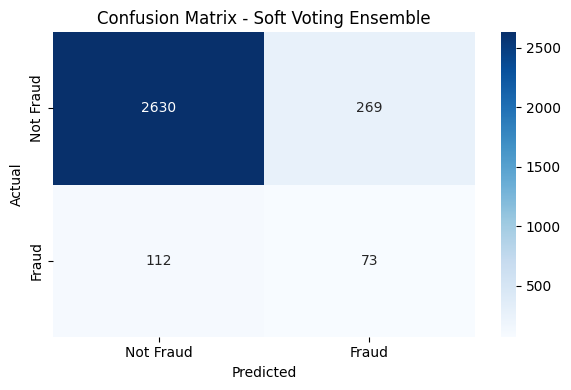

In [61]:
# Step 3: Predict probabilities from both models
# Apply feature selection and preprocessing to X_test before DNN prediction
X_test_for_dnn = preprocessor.transform(X_test)[:, best_features]
dnn_probs = model.predict(X_test_for_dnn).ravel()  # Use the preprocessed X_test_for_dnn

# Apply feature selection to X_test before XGBoost prediction (if necessary)
X_test_for_xgb = preprocessor.transform(X_test)[:, best_features]
xgb_probs = xgb_model.predict_proba(X_test_for_xgb)[:, 1]  # Use preprocessed X_test_for_xgb

# Step 4: Average probabilities (soft voting)
ensemble_probs = 0.5 * dnn_probs + 0.5 * xgb_probs  # or reverse

# Step 5: Tune threshold for optimal F1 score
prec, rec, thresholds = precision_recall_curve(y_test, ensemble_probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"\n Optimal Threshold (F1): {best_thresh:.4f}")

# Step 6: Apply threshold to generate final predictions
y_pred_ensemble = (ensemble_probs >= best_thresh).astype(int)

# Step 7: Print classification report
print("\n Classification Report (Soft Voting):\n")
print(classification_report(y_test, y_pred_ensemble))

# Step 8: Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - Soft Voting Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()